In [ ]:
import numpy as np
from os import path
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix,csc_matrix, diags
from scipy.sparse.dok import dok_matrix
from scipy.sparse import vstack
from scipy.sparse.linalg import lsqr
from scipy      import optimize
import circle_fit as cf

(2431, 2)


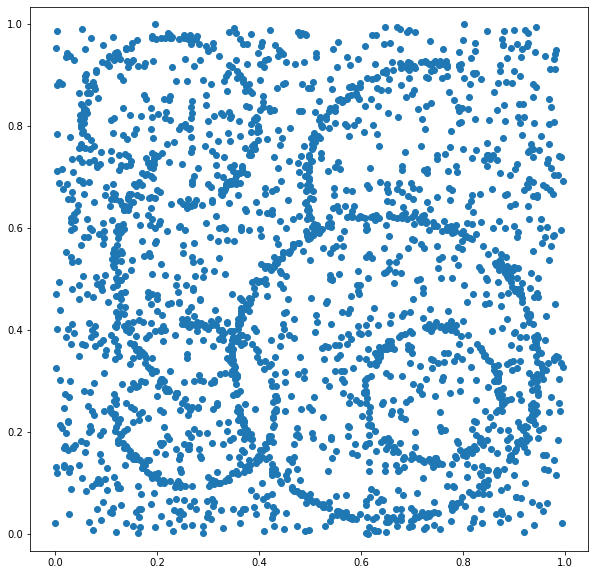

In [ ]:
data = np.load("circles.npy")
print(data.shape)
plt.rcParams["figure.figsize"] = (10,10)
plt.axis("equal")
plt.scatter(data[:,0],data[:,1])

In [ ]:

def circle_from_3_points(z1:complex, z2:complex, z3:complex) -> tuple[complex, float]:
    if (z1 == z2) or (z2 == z3) or (z3 == z1):
        raise ValueError(f'Duplicate points: {z1}, {z2}, {z3}')

    w = (z3 - z1)/(z2 - z1)

    if w.imag == 0:
        raise ValueError(f'Points are collinear: {z1}, {z2}, {z3}')

    c = (z2 - z1)*(w - abs(w)**2)/(2j*w.imag) + z1;  # Simplified denominator
    r = abs(z1 - c);

    return c, r

# 3.1 RANSAC algorithm

In [ ]:
def ransac(data, N, eps, maxCircles= 6):
    cs, rs, circles =  [],[],[]

    #np.random.seed(1)
    #for i in range(1):
    while(len(circles) < maxCircles):
    #while(len(data) > 1000):
        inliers_index=np.array(())
        best_inl_count,r_best, c_best = 0,0,np.array((0,0))
        for n in range(N):
            try:
                ind = np.random.randint(0,len(data)-1,size=3)
                val = data[ind]

            #print(val.shape,val)
            #geht das schöner?
                c , r = circle_from_3_points(complex(val[0,0],val[0,1]),
                                         complex(val[1,0],val[1,1]),
                                         complex(val[2,0],val[2,1]))
            except:
                n-=1
                continue
            c = np.array((c.real,c.imag))
            #print(c)
            inliers = abs(np.sqrt(np.square(data[:,0]-c[0])+np.square(data[:,1]-c[1]))-r) < eps
            inliers_data = data[inliers]
            #print(len(inliers_data))
            if(len(inliers_data) > best_inl_count):
                best_inl_count,c_best,r_best, inliers_index = len(inliers_data),c,r,np.where(inliers)

            #print(data[inliers_index])

        cs.append(c)
        rs.append(r)
        circles.append(data[inliers_index])
        data = np.delete(data,inliers_index,axis=0)
    print(len(circles))
    return cs, rs, circles

In [ ]:
def pltgraph(data,cs,rs):
    plt.rcParams["figure.figsize"] = (10,10)
    plt.axis("equal")
    plt.scatter(data[:,0],data[:,1])
    plt.xlim(0,1)
    plt.ylim(0,1)
    for i in range(len(cs)):
        circle = plt.Circle(cs[i],radius=rs[i], fill=False)
        plt.gca().add_patch(circle)
    plt.show()

6


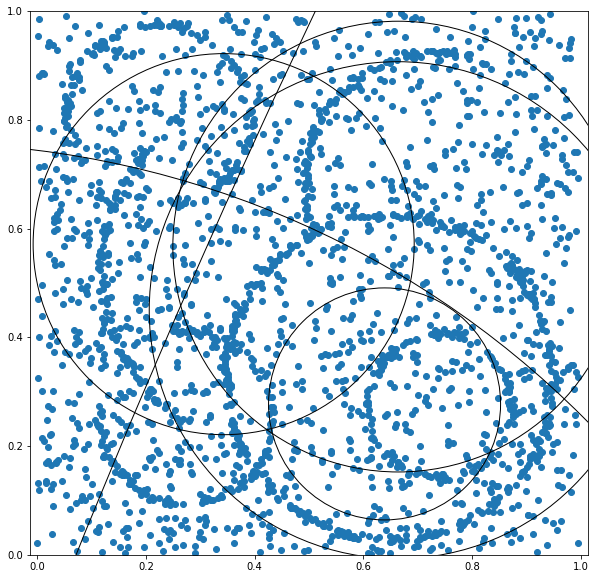

In [ ]:
cs, rs, inliers = ransac(data,15000,0.007)
pltgraph(data,cs,rs)

# 3.2 Algebraic Distance

In [ ]:
def algebr_dist(inliers,cs):
    r_new,x,y = np.array(()),[],[]
    for i in range(len(inliers)):
        xc,yc,r,_ = cf.least_squares_circle((inliers[i]))
        x.append(xc)
        y.append(yc)
        r_new = np.append(r_new,r)
    c_new = np.array((x,y)).T
    return c_new,r_new

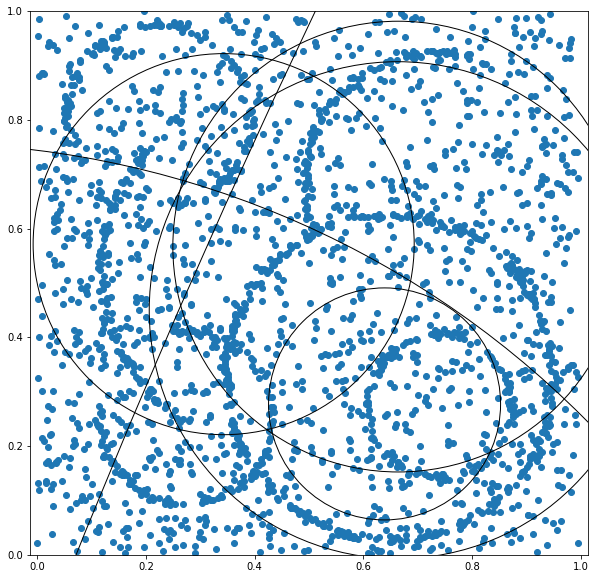

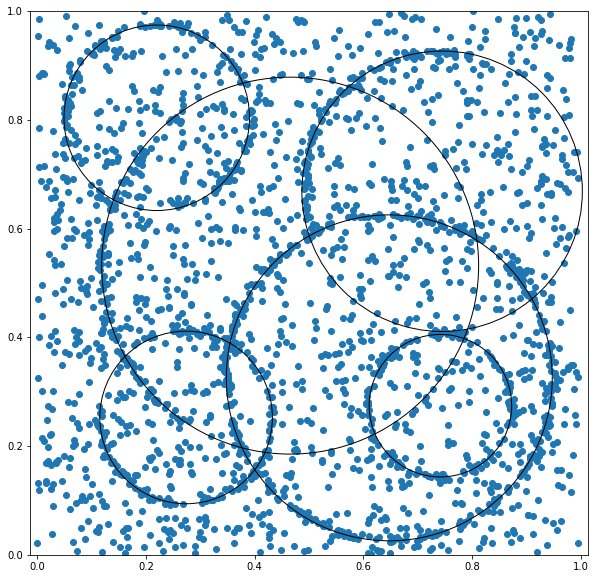

In [ ]:
#cs, rs, inliers = ransac(data,150e00,0.007)
c_new, r_new = algebr_dist(inliers,cs)
pltgraph(data,cs,rs)
pltgraph(data,c_new,r_new)